In [1]:
import torch
print(torch.cuda.is_available())  # должно быть True
print(torch.cuda.get_device_name(0))  # покажет название GPU (RTX 4050)


True
NVIDIA GeForce RTX 4050 Laptop GPU


In [8]:
import pandas as pd

# Загрузка файла с назначением имен колонкам
df = pd.read_csv('dataset_normalized.csv', names=[
    'Open_Time', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Close_Time', 'Quote_Asset_Volume', 'Number_of_Trades',
    'Taker_Buy_Volume', 'Taker_Buy_Quote_Volume'
])

# Преобразование временных меток в нормальный формат даты и времени
df['Open_Time'] = pd.to_datetime(df['Open_Time'], unit='ms')
df['Close_Time'] = pd.to_datetime(df['Close_Time'], unit='ms')

# Просмотр первых строк
print(df.head())

            Open_Time       Open       High        Low      Close      Volume  \
0 2025-02-01 00:00:00  102429.56  102783.71  102198.52  102249.19  1810.34285   
1 2025-02-01 04:00:00  102249.19  102588.57  102118.56  102166.49  1052.21801   
2 2025-02-01 08:00:00  102166.49  102276.99  101412.00  102028.81  2029.14504   
3 2025-02-01 12:00:00  102028.82  102329.01  101730.79  102073.89  1704.67519   
4 2025-02-01 16:00:00  102073.89  102297.99  101448.00  101669.60  1472.58058   

               Close_Time  Quote_Asset_Volume  Number_of_Trades  \
0 2025-02-01 03:59:59.999        1.855825e+08            336147   
1 2025-02-01 07:59:59.999        1.077009e+08            228096   
2 2025-02-01 11:59:59.999        2.066930e+08            418187   
3 2025-02-01 15:59:59.999        1.740051e+08            385831   
4 2025-02-01 19:59:59.999        1.501242e+08            389744   

   Taker_Buy_Volume  Taker_Buy_Quote_Volume  
0         985.25105            1.010047e+08  
1         511.2589

In [1]:
import pandas as pd

df = pd.read_csv('dataset_normalized.csv', names=[
    'Open_Time', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Close_Time', 'Quote_Asset_Volume', 'Number_of_Trades',
    'Taker_Buy_Volume', 'Taker_Buy_Quote_Volume'
])

# рассчитываем процент изменения цены закрытия относительно следующего периода
# т.е. насколько изменится цена на следующей свече (сдвиг вверх на -1)
df['price_change_pct'] = df['Close'].pct_change().shift(-1) * 100

# определяем функцию для классификации изменения цены в target
def classify_change(change):
    if change >= 0.75:
        return 0  # рост цены >= 0.75%
    elif change <= -0.75:
        return 1  # падение цены <= -0.75%
    else:
        return 2  # нейтральное изменение

df['target'] = df['price_change_pct'].apply(classify_change)

df.dropna(subset=['price_change_pct'], inplace=True)

df.drop(columns=['price_change_pct'], inplace=True)

df.to_csv('dataset_with_target.csv', index=False)

print(df.head())



       Open_Time       Open       High        Low      Close      Volume  \
0  1738368000000  102429.56  102783.71  102198.52  102249.19  1810.34285   
1  1738382400000  102249.19  102588.57  102118.56  102166.49  1052.21801   
2  1738396800000  102166.49  102276.99  101412.00  102028.81  2029.14504   
3  1738411200000  102028.82  102329.01  101730.79  102073.89  1704.67519   
4  1738425600000  102073.89  102297.99  101448.00  101669.60  1472.58058   

      Close_Time  Quote_Asset_Volume  Number_of_Trades  Taker_Buy_Volume  \
0  1738382399999        1.855825e+08            336147         985.25105   
1  1738396799999        1.077009e+08            228096         511.25891   
2  1738411199999        2.066930e+08            418187         804.83163   
3  1738425599999        1.740051e+08            385831         854.36304   
4  1738439999999        1.501242e+08            389744         644.31801   

   Taker_Buy_Quote_Volume  target  
0            1.010047e+08       2  
1            5

In [9]:
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
import pandas as pd

df = pd.read_csv('dataset_with_target.csv')

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

clf = TabNetClassifier()
clf.fit(X_train.values, y_train.values,
        eval_set=[(X_test.values, y_test.values)],
        max_epochs=100,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128)

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98833 | val_0_accuracy: 0.52407 |  0:00:01s
epoch 1  | loss: 0.89252 | val_0_accuracy: 0.52407 |  0:00:02s
epoch 2  | loss: 0.88342 | val_0_accuracy: 0.23157 |  0:00:02s
epoch 3  | loss: 0.87829 | val_0_accuracy: 0.52407 |  0:00:03s
epoch 4  | loss: 0.87435 | val_0_accuracy: 0.52407 |  0:00:03s
epoch 5  | loss: 0.87326 | val_0_accuracy: 0.52407 |  0:00:04s
epoch 6  | loss: 0.87315 | val_0_accuracy: 0.52407 |  0:00:04s
epoch 7  | loss: 0.86972 | val_0_accuracy: 0.52407 |  0:00:05s
epoch 8  | loss: 0.86983 | val_0_accuracy: 0.52407 |  0:00:06s
epoch 9  | loss: 0.87315 | val_0_accuracy: 0.52407 |  0:00:06s
epoch 10 | loss: 0.86866 | val_0_accuracy: 0.52407 |  0:00:07s
epoch 11 | loss: 0.8702  | val_0_accuracy: 0.52407 |  0:00:07s
epoch 12 | loss: 0.86888 | val_0_accuracy: 0.52407 |  0:00:08s
epoch 13 | loss: 0.8682  | val_0_accuracy: 0.52407 |  0:00:09s
epoch 14 | loss: 0.86789 | val_0_accuracy: 0.52407 |  0:00:09s
epoch 15 | loss: 0.86722 | val_0_accuracy: 0.52407 |  0

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [10]:
from sklearn.metrics import classification_report

preds = clf.predict(X_test.values)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       802
           1       0.00      0.00      0.00       760
           2       0.52      1.00      0.69      1720

    accuracy                           0.52      3282
   macro avg       0.17      0.33      0.23      3282
weighted avg       0.27      0.52      0.36      3282



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


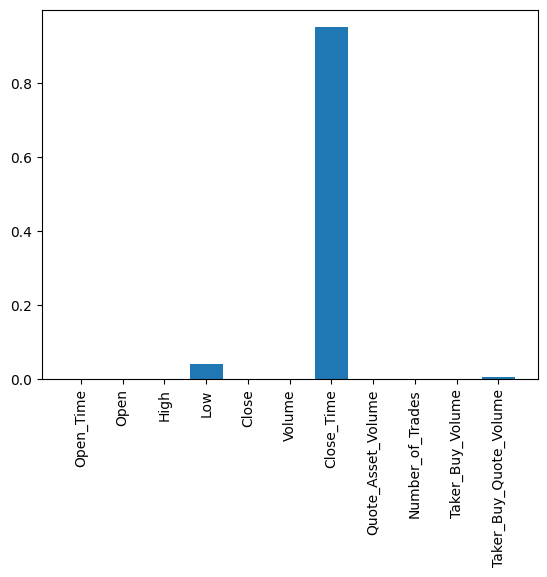

In [11]:
import matplotlib.pyplot as plt

feat_importances = clf.feature_importances_
plt.bar(X.columns, feat_importances)
plt.xticks(rotation=90)
plt.show()